# Pipeline using Tsfresh and Adapt
Packages required include *tsfresh* for feature extraction,
*sklearn* for Random Forest,
*adapt* for Feature Augmentation,
*skopt* for Hyperparameter Tuning and 
*pandas*, *numpy* and *matplotlib* 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tsfresh
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series, impute

from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from adapt.feature_based import FA

from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

from my_package.utils import create_df, plot_data, return_df, roll_data, norm
from my_package.add_columns import create_time_column, create_rul_columns



# Necessary to due to skopt not being up-to-date
np.int = int

## Load Data
Loading Training-Data, Test-Data and Validation-Data

In [2]:
#TODO: Files angeben
dir_data = '../data.nosync/'

#Folder Names
data_s_train    = ['train/Bearing1_1', 'train/Bearing1_2', 'test/Bearing1_5', 'test/Bearing1_6', 'test/Bearing1_7', 
'train/Bearing2_1', 'train/Bearing2_2', 'test/Bearing2_5', 'test/Bearing2_6', 'test/Bearing2_7']
data_s_test     = ['test/Bearing1_3', 'test/Bearing1_4',  
                   'test/Bearing2_3', 'test/Bearing2_4']
data_s_validate = ['validate/Bearing1_3']
data_t_train    = ['train/Bearing3_1', 'train/Bearing3_2']
data_t_test     = ['test/Bearing3_3']
data_t_validate = []

#Creation of df based on folder names
df_s_validate   = return_df(dir_data, data_s_validate)
df_s_train      = return_df(dir_data, data_s_train)
df_s_test       = return_df(dir_data, data_s_test)
df_t_train      = return_df(dir_data, data_t_train)
df_t_test       = return_df(dir_data, data_t_test)
#df_t_validate  = return_df(dir_data, data_t_validate)

# Normalisierung der Daten

In [3]:
df_s_train      = norm(df_s_train)
df_s_test       = norm(df_s_test)
df_s_validate   = norm(df_s_validate)
df_t_train      = norm(df_t_train)
df_t_test       = norm(df_t_test)

# Plot Data

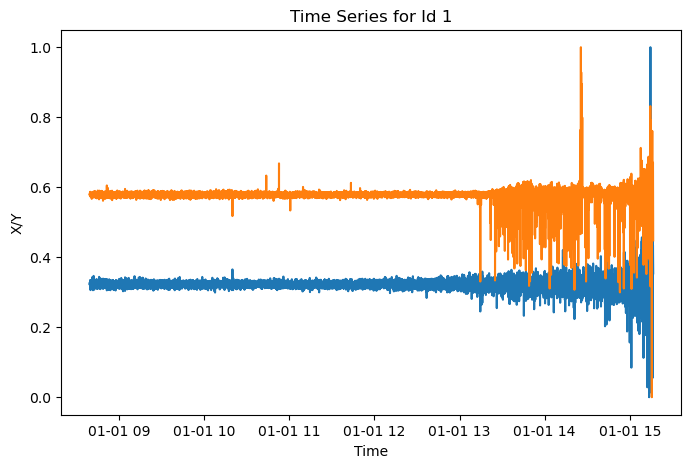

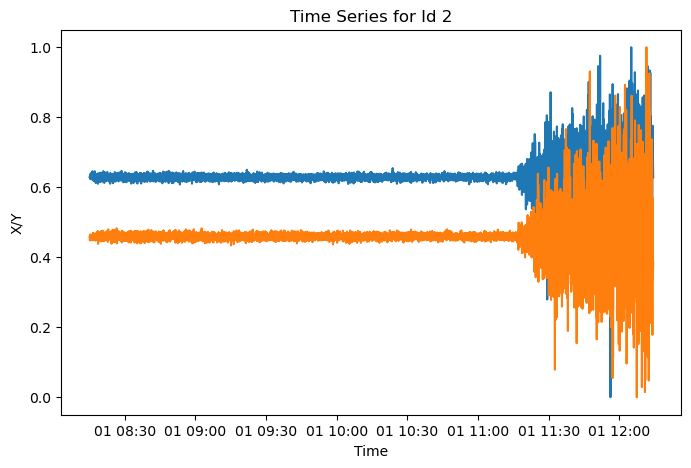

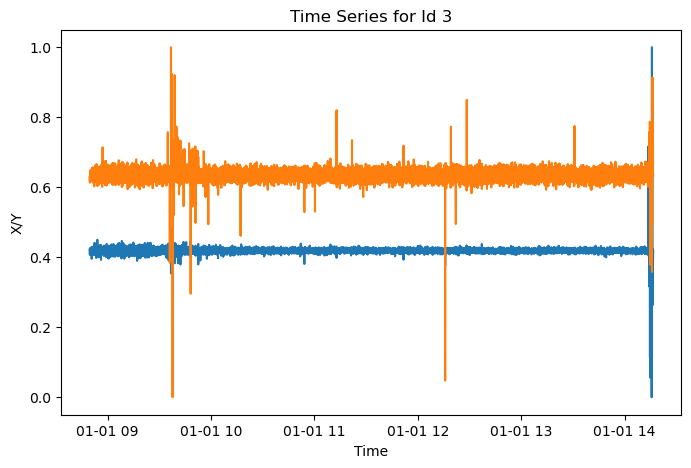

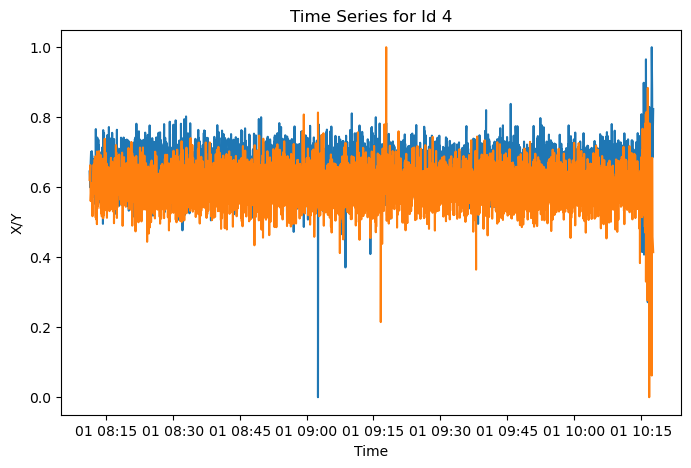

In [4]:
plot_data(df_s_test)

## Roll Data

In [6]:
#TODO: Params festlegen
df_s_train_rolled       = roll_data(df_s_train, min_timeshift=1000, rolling_direction=800)
df_s_test_rolled        = roll_data(df_s_test, min_timeshift=1000, rolling_direction=800)
df_s_validate_rolled    = roll_data(df_s_validate, min_timeshift=1000, rolling_direction=800)
df_t_train_rolled       = roll_data(df_t_train, min_timeshift=1000, rolling_direction=800)
df_t_test_rolled        = roll_data(df_t_test, min_timeshift=1000, rolling_direction=800)

c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s]
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 21/21 [00:02<00:00,  8.42it/s]
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not unifor

In [7]:
df_s_train_rolled.to_pickle("df_s_train_rolled.pkl")
df_s_test_rolled.to_pickle("df_s_test_rolled.pkl")
df_s_validate_rolled.to_pickle("df_s_validate_rolled.pkl")
df_t_train_rolled.to_pickle("df_t_train_rolled.pkl")
df_t_test_rolled.to_pickle("df_t_test_rolled.pkl")

del [df_s_train]
del [df_t_train]
del [df_s_test]
del [df_t_test]
del [df_s_validate]

In [8]:
del [df_s_train_rolled]
del [df_t_train_rolled]
del [df_s_test_rolled]
del [df_t_test_rolled]
del [df_s_validate_rolled]

# Test with Dask Dataframe

In [ ]:
import dask.dataframe as dd
df_temp = df_s_train_rolled.drop(columns=['bearing_id', 'time_end', 'RUL_rolled_class', 'RUL_rolled'])
df = dd.from_pandas(df_temp, npartitions=5)
df

In [ ]:
X = extract_features(df,
                     column_id="id",
                     column_sort="time",
                     default_fc_parameters= ComprehensiveFCParameters(), 
                     impute_function=impute,
                     pivot=False)

In [ ]:
result=X.compute()
result

In [ ]:
y_s_train_distinct = df_s_train_rolled.groupby('id')['RUL_rolled_class'].last()

In [ ]:
X_selected = select_features(result.dropna(axis=0), y_s_train_distinct, ml_task='classification', multiclass=True, show_warnings=True, fdr_level= 0.05)

## Feature Generation

In [6]:
import pandas as pd
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import impute
df_s_train_rolled = pd.read_pickle("df_s_train_rolled.pkl")
df_s_train_rolled.head()
df_s_train_rolled.describe()

,time,x,y,bearing_id,time_end,RUL_rolled_class,RUL_rolled
count,1025509,1.025509e+06,1.025509e+06,1.025509e+06,1025509,1.025509e+06,1.025509e+06
mean,2023-01-01 11:16:21.092575744,5.069124e-01,5.354280e-01,3.992073e+00,2023-01-01 13:28:24.375594240,1.294466e+00,5.140257e-01
min,2023-01-01 07:49:33.660000,0.000000e+00,0.000000e+00,1.000000e+00,2023-01-01 08:19:16.910000,1.000000e+00,0.000000e+00
25%,2023-01-01 09:51:35.840000,4.237941e-01,4.798877e-01,2.000000e+00,2023-01-01 11:58:49.280000,1.000000e+00,3.218819e-01
50%,2023-01-01 10:56:44.430000128,4.610897e-01,5.346950e-01,4.000000e+00,2023-01-01 13:39:38.609999872,1.000000e+00,4.900383e-01
75%,2023-01-01 12:28:49.312000,6.199332e-01,5.672237e-01,5.000000e+00,2023-01-01 14:58:25.129999872,1.000000e+00,7.052565e-01
max,2023-01-01 17:29:12.550000,1.000000e+00,1.000000e+00,1.000000e+01,2023-01-01 17:29:12.550000,3.000000e+00,1.173893e+00
std,NaN,1.047228e-01,9.006123e-02,2.406261e+00,NaN,5.638025e-01,2.655280e-01


In [7]:

# TODO: Params festlegen
X_s_train = extract_features(df_s_train_rolled.drop(columns=['time_end', 'bearing_id', 'RUL_rolled_class', 'RUL_rolled']), column_id='id', column_sort='time', default_fc_parameters= ComprehensiveFCParameters(), impute_function=impute)

Feature Extraction:  87%|████████▋ | 45/52 [45:01<03:15, 27.86s/it]   

In [14]:
X_s_train.to_pickle("X_s_train.pkl")
del[X_s_train]

## Feature Selection

In [ ]:
y_s_train_distinct = df_s_train_rolled.groupby('id')['RUL_rolled_class'].last()
y_s_test_distinct = df_s_test_rolled.groupby('id')['RUL_rolled_class'].last()
y_s_validate_distinct = df_s_validate_rolled.groupby('id')['RUL_rolled_class'].last()
y_t_test_distinct = df_t_test_rolled.groupby('id')['RUL_rolled_class'].last()
y_t_train_distinct = df_t_train_rolled.groupby('id')['RUL_rolled_class'].last()

Identify relevant features based on labeled data. Relevancy is identified via fdr_level

In [ ]:
#TODO: fdr_level festlegen
X_s_train_selected = select_features(X_s_train, y_s_train_distinct, ml_task='classification', multiclass=True, show_warnings=True, fdr_level= 0.0000010)

c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\tsfresh\feature_selection\relevance.py:222: RuntimeWarning: [test_feature_significance] Constant features: x__variance_larger_than_standard_deviation, x__has_duplicate_max, x__has_duplicate_min, x__has_duplicate, x__symmetry_looking__r_0.0, x__symmetry_looking__r_0.05, x__symmetry_looking__r_0.1, x__symmetry_looking__r_0.15000000000000002, x__symmetry_looking__r_0.2, x__symmetry_looking__r_0.25, x__symmetry_looking__r_0.30000000000000004, x__symmetry_looking__r_0.35000000000000003, x__symmetry_looking__r_0.4, x__symmetry_looking__r_0.45, x__symmetry_looking__r_0.5, x__symmetry_looking__r_0.55, x__symmetry_looking__r_0.6000000000000001, x__symmetry_looking__r_0.65, x__symmetry_looking__r_0.7000000000000001, x__symmetry_looking__r_0.75, x__symmetry_looking__r_0.8, x__symmetry_looking__r_0.8500000000000001, x__symmetry_looking__r_0.9, x__symmetry_looking__r_0.9500000000000001, x__large_standard_deviation__r_0.15000000000000002, x__

In [ ]:
X_s_train_selected

x__number_peaks__n_50  \
1  2023-01-01 10:10:07.910                   15.0   
   2023-01-01 10:29:09.312                   24.0   
   2023-01-01 10:48:13.260                   33.0   
   2023-01-01 11:07:14.664                   40.0   
   2023-01-01 11:26:18.610                   47.0   
...                                           ...   
9  2023-01-01 09:51:14.440                   19.0   
   2023-01-01 10:10:18.380                   27.0   
   2023-01-01 10:29:19.790                   38.0   
   2023-01-01 10:48:23.730                   47.0   
10 2023-01-01 09:12:38.280                   12.0   

                            y__fft_aggregated__aggtype_"variance"  \
1  2023-01-01 10:10:07.910                           27727.064948   
   2023-01-01 10:29:09.312                           84959.218343   
   2023-01-01 10:48:13.260                          179461.524464   
   2023-01-01 11:07:14.664                          306264.438757   
   2023-01-01 11:26:18.610                          468355.052852   
...                                                           ...   
9  2023-01-01 09:51:14.440                          109564.984995   
   2023-01-01 10:10:18.380                          217242.151305   
   2023-01-01 10:29:19.790                          361180.237544   
   2023-01-01 10:48:23.730                          541325.816410   
10 2023-01-01 09:12:38.280                           38961.398513   

                            x__number_peaks__n_5  \
1  2023-01-01 10:10:07.910                 113.0   
   2023-01-01 10:29:09.312                 181.0   
   2023-01-01 10:48:13.260                 255.0   
   2023-01-01 11:07:14.664                 330.0   
   2023-01-01 11:26:18.610                 404.0   
...                                          ...   
9  2023-01-01 09:51:14.440                 187.0   
   2023-01-01 10:10:18.380                 262.0   
   2023-01-01 10:29:19.790                 330.0   
   2023-01-01 10:48:23.730                 404.0   
10 2023-01-01 09:12:38.280                 111.0   

                            x__permutation_entropy__dimension_7__tau_1  \
1  2023-01-01 10:10:07.910                                    6.919338   
   2023-01-01 10:29:09.312                                    7.342056   
   2023-01-01 10:48:13.260                                    7.602030   
   2023-01-01 11:07:14.664                                    7.759788   
   2023-01-01 11:26:18.610                                    7.883312   
...                                                                ...   
9  2023-01-01 09:51:14.440                                    7.389982   
   2023-01-01 10:10:18.380                                    7.631150   
   2023-01-01 10:29:19.790                                    7.786106   
   2023-01-01 10:48:23.730                                    7.895260   
10 2023-01-01 09:12:38.280                                    6.951588   

                            x__fft_aggregated__aggtype_"variance"  \
1  2023-01-01 10:10:07.910                           29311.804877   
   2023-01-01 10:29:09.312                           87630.508850   
   2023-01-01 10:48:13.260                          178799.619521   
   2023-01-01 11:07:14.664                          305599.940151   
   2023-01-01 11:26:18.610                          466088.967087   
...                                                           ...   
9  2023-01-01 09:51:14.440                          113647.666327   
   2023-01-01 10:10:18.380                          221521.011804   
   2023-01-01 10:29:19.790                          364855.309611   
   2023-01-01 10:48:23.730                          538776.928850   
10 2023-01-01 09:12:38.280                           28453.094268   

                            x__range_count__max_1__min_-1  \
1  2023-01-01 10:10:07.910                         1221.0   
   2023-01-01 10:29:09.312                         2021.0   
   2023-01-01 10:48:13.260          

In [ ]:
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_s_train_selected)

In [ ]:
X_s_validate_selected   = extract_features(df_s_validate_rolled.drop(columns=['time_end', 'bearing_id', 'RUL_rolled_class', 'RUL_rolled']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_s_test_selected   = extract_features(df_s_test_rolled.drop(columns=['time_end', 'bearing_id', 'RUL_rolled_class', 'RUL_rolled']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_t_train_selected  = extract_features(df_t_train_rolled.drop(columns=['time_end', 'bearing_id', 'RUL_rolled_class', 'RUL_rolled']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)
X_t_test_selected  = extract_features(df_t_test_rolled.drop(columns=['time_end', 'bearing_id', 'RUL_rolled_class', 'RUL_rolled']), column_id='id', column_sort='time', kind_to_fc_parameters= kind_to_fc_parameters,impute_function=impute)

Feature Extraction:  98%|█████████▊| 41/42 [04:59<00:07,  7.30s/it]


MemoryError: Unable to allocate 79.6 GiB for an array with shape (59673, 59673, 3) and data type float64

In [ ]:
kind_to_fc_parameters

{'x': {'number_peaks': [{'n': 50}, {'n': 5}, {'n': 1}, {'n': 3}, {'n': 10}],
  'permutation_entropy': [{'dimension': 7, 'tau': 1},
   {'dimension': 6, 'tau': 1}],
  'fft_aggregated': [{'aggtype': 'variance'}],
  'range_count': [{'max': 1, 'min': -1}, {'max': 1000000000000.0, 'min': 0}],
  'length': None,
  'count_below_mean': None,
  'count_above_mean': None,
  'cid_ce': [{'normalize': True}],
  'number_cwt_peaks': [{'n': 5}, {'n': 1}]},
 'y': {'fft_aggregated': [{'aggtype': 'variance'}],
  'count_below_mean': None,
  'number_peaks': [{'n': 3}, {'n': 5}, {'n': 1}, {'n': 10}, {'n': 50}],
  'range_count': [{'max': 1000000000000.0, 'min': 0}, {'max': 1, 'min': -1}],
  'length': None,
  'cid_ce': [{'normalize': True}],
  'number_cwt_peaks': [{'n': 1}, {'n': 5}],
  'sum_of_reoccurring_data_points': None,
  'fft_coefficient': [{'attr': 'real', 'coeff': 0},
   {'attr': 'abs', 'coeff': 0}],
  'sum_values': None,
  'ratio_value_number_to_time_series_length': None,
  'count_above_mean': None,
  

## Data Processing

## Daten

In [ ]:
Xs_train    = X_s_train_selected
Xs_test     = X_s_test_selected[Xs_train.columns]
Xs_val      = X_s_validate_selected[Xs_train.columns]
Xt_train    = X_t_train_selected[Xs_train.columns]
Xt_test     = X_t_test_selected[Xs_train.columns]
ys_train    = y_s_train_distinct
ys_test     = y_s_test_distinct
ys_val      = y_s_validate_distinct
yt_train    = y_t_train_distinct
yt_test     = y_t_test_distinct

## Hyperparameter Optimization

In [21]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 100), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 100),
        "min_samples_split": Integer(2, 100),
        "n_estimators": Integer(50, 1000)
    }

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=150, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=3
                                    )

forest_bayes_search.fit(Xs_train, ys_train) # callback=on_step will print score after each iteration

best_params = forest_bayes_search.best_params_
print("Best Hyperparameters:", best_params)
best_model = forest_bayes_search.best_estimator_
accuracy = best_model.score(Xs_val, ys_val)
print("Accuracy on Validation Data:", accuracy)

c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point 

Best Hyperparameters: OrderedDict([('bootstrap', False), ('max_depth', 92), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 429)])
Accuracy on Validation Data: 0.6428571428571429


## Training

In [22]:
model = FA(forest_bayes_search.best_estimator_, Xt=Xt_train[:-6], yt=yt_train[:-6], random_state=0)

model.fit(Xs_train, ys_train)


model.score(Xt_train, yt_train)
print(classification_report(yt_train, model.predict(Xt_train)))

Fit transform...
Previous shape: (44, 177)
New shape: (56, 531)
Fit Estimator...
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00        10

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [31]:
print(classification_report(yt_test, model.predict(Xt_test)))

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3



c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Spielplatz

In [ ]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(50, 900)
    }

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, #cv=2
                                    )

forest_bayes_search.fit(Xs_test, ys_test) # callback=on_step will print score after each iteration

In [ ]:
forest_bayes_search.best_score_

## Daten

In [ ]:
Xs_train    = X_s_train_selected
Xs_test     = X_s_test_selected[Xs_train.columns]
Xs_val      = X_s_validate_selected[Xs_train.columns]
Xt_train    = X_t_train_selected[Xs_train.columns]
Xt_test     = X_t_test_selected[Xs_train.columns]
ys_train    = y_s_train_distinct
ys_test     = y_s_test_distinct
ys_val      = y_s_validate_distinct
yt_train    = y_t_train_distinct
yt_test     = y_t_test_distinct


## Modelstruktur

In [ ]:
forest_clf = RandomForestClassifier()

search_space = {
        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(1, 20), # values of max_depth are integers from 1 to 20
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(50, 900)
    }

## Hyperparameteroptimierung Source Domain

In [ ]:
forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=3
                                    )

forest_bayes_search.fit(Xs_train, ys_train) # callback=on_step will print score after each iteration

best_params = forest_bayes_search.best_params_
print("Best Hyperparameters:", best_params)
best_model = forest_bayes_search.best_estimator_
accuracy = best_model.score(Xs_val, ys_val)
print("Accuracy on Validation Data:", accuracy)

## Transfer Learning

In [ ]:
model = FA(forest_bayes_search.best_estimator_, Xt=Xt_train, yt=yt_train, random_state=0)

model.fit(Xs_train, ys_train)


model.score(Xt_train, yt_train)

In [ ]:
Xt_train

# Playground Time Series Segmentation

In [ ]:
from my_package.utils import return_df
from my_package.utils import create_df, plot_data, return_df, roll_data, norm
from sklearn.preprocessing import StandardScaler
dir_data = '../data.nosync/'

data_s_train_1    = ['train/Bearing1_1']
data_s_train_2    = ['train/Bearing1_2']
df_s_train_1      = return_df(dir_data, data_s_train_1)
df_s_train_2        = return_df(dir_data, data_s_train_2)
data_s_test_3     = ['test/Bearing2_3']
data_s_test_4   =  ['test/Bearing2_4']
data_s_test_5 = ['test/Bearing2_5']
data_s_test_6 = ['test/Bearing2_6']
df_s_test_3   = return_df(dir_data, data_s_test_3)
df_s_test_4    = return_df(dir_data, data_s_test_4)
df_s_test_5    = return_df(dir_data, data_s_test_5)
df_s_test_6    = return_df(dir_data, data_s_test_6)
df_s_train_1 = norm(df_s_train_1)
df_s_train_2 = norm(df_s_train_2)
df_s_test_3 = norm(df_s_test_3)
df_s_test_4 = norm(df_s_test_4)
df_s_test_5 = norm(df_s_test_5)
df_s_test_6 = norm(df_s_test_6)

scaler = StandardScaler()

# Fit and transform the 'x' column
df_s_test_3['x'] = scaler.fit_transform(df_s_test_3[['x']])
df_s_test_3['y'] = scaler.fit_transform(df_s_test_3[['y']])
df_s_test_5['x'] = scaler.fit_transform(df_s_test_5[['x']])
df_s_test_5['y'] = scaler.fit_transform(df_s_test_5[['y']])
df_s_test_6['x'] = scaler.fit_transform(df_s_test_6[['x']])
df_s_test_6['y'] = scaler.fit_transform(df_s_test_6[['y']])
df_s_test_4['x'] = scaler.fit_transform(df_s_test_4[['x']])
df_s_test_4['y'] = scaler.fit_transform(df_s_test_4[['y']])
df_s_train_1['x'] = scaler.fit_transform(df_s_train_1[['x']])
df_s_train_1['y'] = scaler.fit_transform(df_s_train_1[['y']])
df_s_train_2['x'] = scaler.fit_transform(df_s_train_2[['x']])
df_s_train_2['y'] = scaler.fit_transform(df_s_train_2[['y']])

df_list = [df_s_train_1, df_s_train_2, df_s_test_3, df_s_test_4, df_s_test_5, df_s_test_6]

In [ ]:
from my_package.segmentation import segment

segment(df_list)